# AMAL : TP4

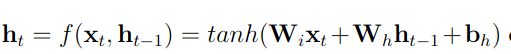

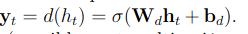

In [2]:
import math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device used : {device}")

device used : cuda


In [3]:
class Test(nn.Module):
    
    def __init__(self,_input,_output):
        super().__init__()
        self._input =_input 
        self._output = _output
        
    def forward(self,x):
        net = nn.Sequential(
            nn.Linear(self._input,self._output),
            nn.Sigmoid()
        )
        return net(x)

In [4]:
test = Test(4,5)
x = torch.randn(100,4)
y = test(x)
print(y.shape)
print(test.state_dict())





[tensor1,tensor2] => tensor([tensor1,tensor2])

SyntaxError: invalid syntax (88343783.py, line 11)

In [5]:

class RNN(nn.Module):
    
    def __init__(self,nb_dim,nb_latent,nb_output,nb_timestep,device) :
        super().__init__()
        
        self.nb_dim = nb_dim
        self.nb_latent = nb_latent
        self.nb_output = nb_output
        self.nb_timestep = nb_timestep
        
        self.weights_i = nn.Linear(nb_dim, nb_latent , bias = False)
        
        self.weights_h = nn.Linear(nb_latent, nb_latent)
        
        self.weights_d = nn.Sequential(
            nn.Linear(nb_latent, 10),
            nn.ReLU(),
            nn.Linear(10, 8),
            nn.ReLU(),
            nn.Linear(8, nb_output)
        )
        
        
    def onestep(self,x,h) :
        """
        input :
        x : batch * dim
        h : batch * latent
        
        return :
            batch * latent
        """
        return torch.tanh((self.weights_i(x) +  self.weights_h(h)))
    
    def forward(self,x,h) :
        """
        input : 
        x : length * batch * dim
        h : batch * latent 
        return :
            length * batch * latent
        """
        result = list()
        
        for t in range(x.shape[0]) :
            
            h = self.onestep(x[t],h)
            
            result.append(h.unsqueeze(0))
            
        result_t = torch.cat(result,dim=0)
        
        return result_t
        
    def decode(self,h) :
        """
        input : 
        h : batch * latent
        
        return :
            batch * output
        """
        return torch.sigmoid(self.weights_d(h))

In [6]:
class SampleMetroDataset(Dataset):
    
    def __init__(self, data,length=20,stations_max=None):
        """
            * data : tenseur des données au format  Nb_days x Nb_slots x Nb_Stations x {In,Out}
            * length : longueur des séquences d'exemple
            * stations_max : normalisation à appliquer
        """
        self.data, self.length= data, length
        ## Si pas de normalisation passée en entrée, calcul du max du flux entrant/sortant
        self.stations_max = stations_max if stations_max is not None else torch.max(self.data.view(-1,self.data.size(2),self.data.size(3)),0)[0]
        ## Normalisation des données
        self.data = self.data / self.stations_max
        self.nb_days, self.nb_timeslots, self.classes = self.data.size(0), self.data.size(1), self.data.size(2)

    def __len__(self):
        ## longueur en fonction de la longueur considérée des séquences
        return self.classes*self.nb_days*(self.nb_timeslots - self.length)

    def __getitem__(self,i):
        ## transformation de l'index 1d vers une indexation 3d
        ## renvoie une séquence de longueur length et l'id de la station.
        station = i // ((self.nb_timeslots-self.length) * self.nb_days)
        i = i % ((self.nb_timeslots-self.length) * self.nb_days)
        timeslot = i // self.nb_days
        day = i % self.nb_days
        return self.data[day,timeslot:(timeslot+self.length),station],station

class ForecastMetroDataset(Dataset):
    
    def __init__(self, data,length=20,stations_max=None):
        """
            * data : tenseur des données au format  Nb_days x Nb_slots x Nb_Stations x {In,Out}
            * length : longueur des séquences d'exemple
            * stations_max : normalisation à appliquer
        """
        self.data, self.length= data,length
        ## Si pas de normalisation passée en entrée, calcul du max du flux entrant/sortant
        self.stations_max = stations_max if stations_max is not None else torch.max(self.data.view(-1,self.data.size(2),self.data.size(3)),0)[0]
        ## Normalisation des données
        self.data = self.data / self.stations_max
        self.nb_days, self.nb_timeslots, self.classes = self.data.size(0), self.data.size(1), self.data.size(2)

    def __len__(self):
        ## longueur en fonction de la longueur considérée des séquences
        return self.nb_days*(self.nb_timeslots - self.length)

    def __getitem__(self,i):
        ## Transformation de l'indexation 1d vers indexation 2d
        ## renvoie x[d,t:t+length-1,:,:], x[d,t+1:t+length,:,:]
        timeslot = i // self.nb_days
        day = i % self.nb_days
        return self.data[day,timeslot:(timeslot+self.length-1)],self.data[day,(timeslot+1):(timeslot+self.length)]

In [7]:
def get_Xy(ds) :
    X = list()
    y = list()

    for i in range(len(ds)):
        x_,y_ = ds.__getitem__(i)
        X.append( x_.detach().numpy() )
        y.append( y_ )

    y = np.asarray(y)
    X = np.asarray(X , dtype = np.float32)
    return X,y

def score_many_to_one(Xy, data, rnn) :
    X,y = Xy
    Xt = torch.as_tensor(X, dtype = torch.float32).transpose(0,1)

    h = torch.zeros((Xt.shape[1],nb_latent)).to(device)
    y_pred = rnn.forward(Xt,h)[-1,:,:] # on garde le dernier
    y_decode = torch.argmax(rnn.decode(y_pred),dim=1).detach().numpy()
    return (y_decode == y).sum() / len(y) * 100

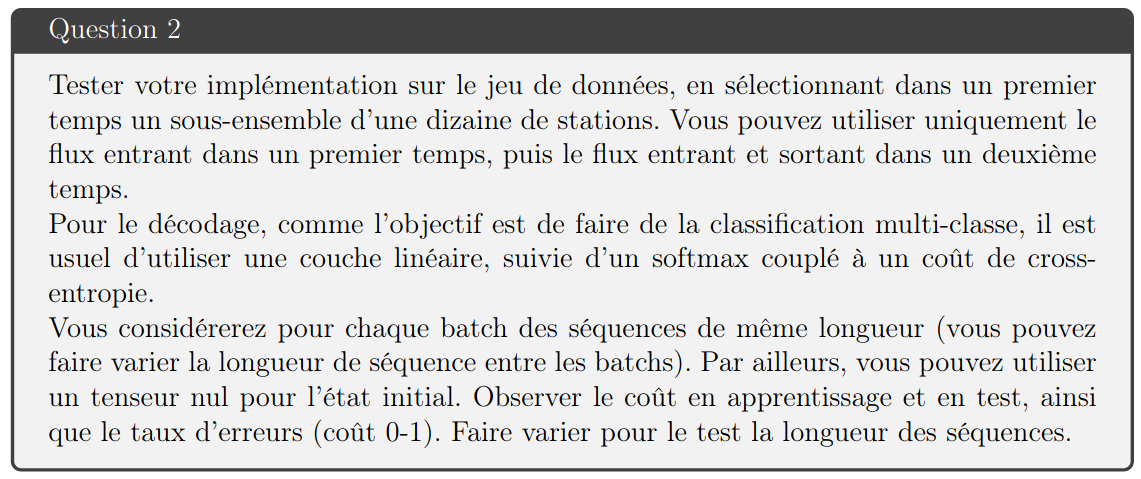

In [8]:
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
device =  torch.device("cpu") #  torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device : {device}")

# Nombre de stations utilisé
CLASSES = 10
#Longueur des séquences
LENGTH = 20
# Dimension de l'entrée (1 (in) ou 2 (in/out))
DIM_INPUT = 2
#Taille du batch
BATCH_SIZE = 32

def onehot(y):
    onehot = np.zeros((y.shape[0],CLASSES))
    onehot[np.arange(y.shape[0]), y] = 1
    return onehot

PATH = "data/"
matrix_train, matrix_test = torch.load(open(PATH+"hzdataset.pch","rb"))
ds_train = SampleMetroDataset(matrix_train[:, :, :CLASSES, :DIM_INPUT], length=LENGTH)
ds_test=SampleMetroDataset(matrix_test[:, :, :CLASSES, :DIM_INPUT], length = LENGTH, stations_max = ds_train.stations_max)
data_train = DataLoader(ds_train,batch_size=BATCH_SIZE,shuffle=True)
data_test = DataLoader(ds_test, batch_size=BATCH_SIZE,shuffle=False)

device : cpu


In [135]:
nb_dim = DIM_INPUT
nb_output = CLASSES
nb_timestep = LENGTH
batch = BATCH_SIZE
nb_latent = 10
nb_epoch = 500

rnn = RNN(nb_dim,nb_latent,nb_output,nb_timestep,device)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

writer = SummaryWriter("./runs/tp4_question2")

print(f"batch : {batch}")
print(f"nb_dim : {nb_dim}")
print(f"length : {nb_timestep}")
print(f"nb_latent : {nb_latent}")


batch : 32
nb_dim : 2
length : 20
nb_latent : 10


In [136]:
list_error = list()
list_score_train = list()
list_score_test = list()

Xytrain = get_Xy(ds_train)
Xytest = get_Xy(ds_test)

for epoch in tqdm(range(nb_epoch)) :

    list_err = list()
    
    h = torch.zeros((batch,nb_latent)).to(device)
    
    for X,y in data_train :
        
        X = X.transpose(0,1)
        
        print(X.shape,y.shape)
        input()
        
        if X.shape[1] != batch :
            break
        
        y_pred = rnn.forward(X,h)

        r = y_pred[-1,:,:]
        
        # print(r.shape)
        y_decode = rnn.decode(r)
        
        ce = torch.nn.CrossEntropyLoss()
        
        loss = ce(y_decode,y)
        
        
        list_err.append(loss.cpu().detach().numpy())
        
        writer.add_scalar('TP4 : Loss/train RNN', loss.cpu().detach().numpy(), epoch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    list_score_train.append(score_many_to_one(Xytrain, data_train, rnn))
    list_score_test.append(score_many_to_one(Xytest, data_test, rnn))
        
    avg_error = sum(list_err) / len(list_err)
    list_error.append(avg_error)

  0%|                                                   | 0/500 [00:00<?, ?it/s]

torch.Size([20, 32, 2]) torch.Size([32])


  0%|                                                   | 0/500 [00:26<?, ?it/s]


KeyboardInterrupt: Interrupted by user

In [121]:
list_error = list()
list_score_train = list()
list_score_test = list()

Xytrain = get_Xy(ds_train)
Xytest = get_Xy(ds_test)

for epoch in tqdm(range(nb_epoch)) :

    list_err = list()
    
    h = torch.zeros((batch,nb_latent)).to(device)
    
    for X,y in data_train :
        
        X = X.transpose(0,1)
        
        if X.shape[1] != batch :
            break
        
        y_pred = rnn.forward(X,h)

        r = y_pred[-1,:,:]
        
        # print(r.shape)
        y_decode = rnn.decode(r)
        
        ce = torch.nn.CrossEntropyLoss()
        
        loss = ce(y_decode,y)
        
        
        list_err.append(loss.cpu().detach().numpy())
        
        writer.add_scalar('TP4 : Loss/train RNN', loss.cpu().detach().numpy(), epoch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    list_score_train.append(score_many_to_one(Xytrain, data_train, rnn))
    list_score_test.append(score_many_to_one(Xytest, data_test, rnn))
        
    avg_error = sum(list_err) / len(list_err)
    list_error.append(avg_error)

100%|█████████████████████████████████████████| 500/500 [18:42<00:00,  2.25s/it]


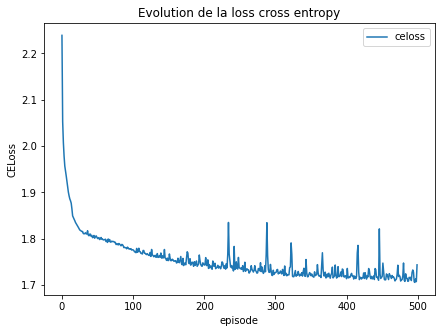

In [122]:
plt.figure(figsize=(7,5))
plt.title("Evolution de la loss cross entropy")
plt.xlabel("episode")
plt.ylabel("CELoss")
plt.plot(list_error, label = "celoss")
plt.legend()
plt.show()

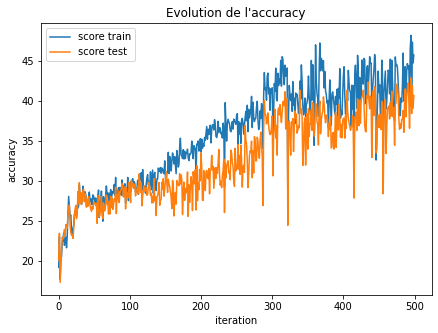

In [124]:
plt.figure(figsize=(7,5))
plt.title("Evolution de l'accuracy")
plt.xlabel("iteration")
plt.ylabel("accuracy")
plt.plot(list_score_train, label = "score train")
plt.plot(list_score_test, label = "score test")
plt.legend()
plt.show()

## Taux d'erreurs 0-1

In [125]:
print(f"taille trainset : {len(ds_train)}")
print(f"taille testset : {len(ds_test)}")

score_train = score_many_to_one(get_Xy(ds_train), data_train, rnn) 
score_test = score_many_to_one(get_Xy(ds_test), data_test, rnn) 

print(f"score en train = {score_train}%")
print(f"score en test = {score_test}%")


taille trainset : 9540
taille testset : 3710
score en train = 45.70230607966457%
score en test = 40.64690026954178%


In [12]:
len(data_train)

X_train = list()
y_train = list()

for i in range(len(data_train)):
    x,y = ds_train.__getitem__(i)
    X_train.append( x.detach().numpy() )
    y_train.append( y )

y_train = np.asarray(y_train)
X_train = np.asarray(X_train , dtype = np.float32)

print("y_train : ",y_train.shape)
print("X_train : ",X_train.shape)

X_train_t = torch.as_tensor(X_train, dtype = torch.float32).transpose(0,1)

y_pred = rnn(X_train_t)

y_pred_t = torch.cat(y_pred)

print(y_pred_t.shape)

y_pred_t = torch.argmax(y_t, dim = 1)

print(y_pred_t.shape)
y_train_t = torch.as_tensor(y_train)
print(y_train_t.shape)



y_train :  (299,)
X_train :  (299, 20, 2)


TypeError: forward() missing 1 required positional argument: 'h'

## Modele de séquence multivariée

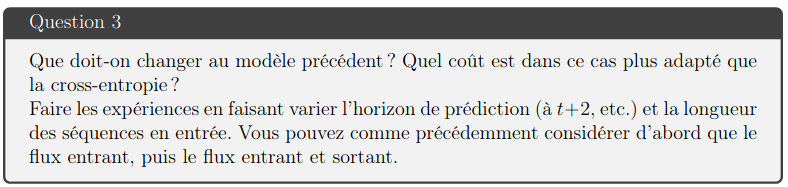

In [17]:
# class RNN(nn.Module):
    
#     def __init__(self,nb_dim,nb_latent,nb_output,nb_timestep,device) :
#         super().__init__()
        
#         self.nb_dim = nb_dim
#         self.nb_latent = nb_latent
#         self.nb_output = nb_output
#         self.nb_timestep = nb_timestep
        
#         self.weights_i = nn.Linear(nb_dim, nb_latent)
        
#         self.weights_h = nn.Linear(nb_latent, nb_latent)
        
#         self.weights_d = nn.Sequential(
#             nn.Linear(nb_latent, 10),
#             nn.ReLU(),
#             nn.Linear(10, 8),
#             nn.ReLU(),
#             nn.Linear(8, nb_output)
#         )
        
        
#     def onestep(self,x,h) :
#         """
#         input :
#         x : batch * dim
#         h : batch * latent
        
#         return :
#             batch * latent
#         """
#         return torch.tanh((self.weights_i(x) +  self.weights_h(h) ))
    
#     def forward(self,x,h) :
#         """
#         input : 
#         x : length * batch * dim
#         h : batch * latent 
#         return :
#             length * batch * latent
#         """
#         result = list()
        
#         for t in range(x.shape[0]) :
            
#             h = self.onestep(x[t],h)
        
#         y = self.decode(h) # calcul de la derniere sortie
        
#         for t in range(x.shape[0]) :
            
#             h = self.onestep(y,h)
            
#             y = self.decode(h)
            
#             result.append(y.unsqueeze(0))
            
#         result_t = torch.cat(result,dim=0)
        
#         return result_t
        
#     def decode(self,h) :
#         """
#         input : 
#         h : batch * latent
        
#         return :
#             batch * output
#         """
#         return torch.softmax(torch.sigmoid(self.weights_d(h)),dim=1)

In [172]:
from torch.utils.data import  DataLoader
import torch


device = torch.device("cpu")

# Nombre de stations utilisé
CLASSES = 10
#Longueur des séquences
LENGTH = 20
# Dimension de l'entrée (1 (in) ou 2 (in/out))
DIM_INPUT = 2
#Taille du batch
BATCH_SIZE = 32

PATH = "./data/"

matrix_train, matrix_test = torch.load(open(PATH+"hzdataset.pch", "rb"))
ds_train = ForecastMetroDataset(matrix_train[:, :, :CLASSES, :DIM_INPUT], length=LENGTH)
ds_test = ForecastMetroDataset(matrix_test[:, :, :CLASSES, :DIM_INPUT], length=LENGTH, stations_max=ds_train.stations_max)
data_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
data_test = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)


print(len(data_train))

nb_dim = DIM_INPUT
nb_output = DIM_INPUT
nb_timestep = LENGTH
batch = BATCH_SIZE
nb_latent = 10
nb_epoch = 100

rnn = RNN(nb_dim,nb_latent,nb_output,nb_timestep,device)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

writer = SummaryWriter("./runs/tp4_question2")

n = 10

print(f"batch : {batch}")
print(f"nb_dim : {nb_dim}")
print(f"length : {nb_timestep}")
print(f"nb_latent : {nb_latent}")

list_error = list()
list_score_train = list()
list_score_test = list()

# Xytrain = get_Xy(ds_train)
# Xytest = get_Xy(ds_test)

gare = 1

for epoch in tqdm(range(nb_epoch)) :

    list_err = list()
    
    h = torch.zeros((batch,nb_latent)).to(device)
    
    for X,y in data_train :
        # Apprentissage sur la gare 0
        
        X = X[:,:,gare,:].transpose(0,1) 
        y = y[:,:,gare,:].transpose(0,1)
        
        
        if X.shape[1] != batch :
            break
        
        y_pred = rnn.forward(X,h)
        
        # print(r.shape)
        y_decode = rnn.decode(y_pred)
        
        mse = torch.nn.SmoothL1Loss()
        
        loss = mse(y_decode,y)
        
        list_err.append(loss.cpu().detach().numpy())
        
        writer.add_scalar('TP4 : Loss/train RNN', loss.cpu().detach().numpy(), epoch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    list_score_train.append(score_many_to_one(Xytrain, data_train, rnn))
    list_score_test.append(score_many_to_one(Xytest, data_test, rnn))
        
    avg_error = sum(list_err) / len(list_err)
    list_error.append(avg_error)

30
batch : 32
nb_dim : 2
length : 20
nb_latent : 10


100%|█████████████████████████████████████████| 100/100 [00:20<00:00,  4.99it/s]


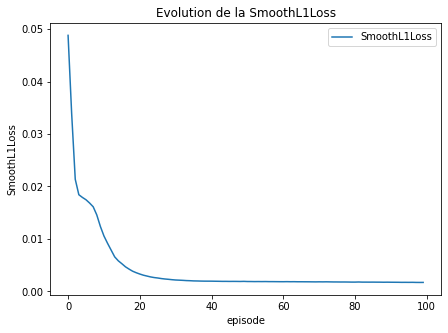

In [173]:
plt.figure(figsize=(7,5))
plt.title("Evolution de la SmoothL1Loss")
plt.xlabel("episode")
plt.ylabel("SmoothL1Loss")
plt.plot(list_error, label = "SmoothL1Loss")
plt.legend()
plt.show()

## Génération de séquence

In [11]:
import numpy as np
words = list()
text = ""

with open('./data/trump_full_speech.txt') as file:
    next_line = file.readline()
    while next_line:
        
        words += next_line.split()
        text += next_line
        
        next_line = file.readline()
print(len(words))
# words = words[:10000]
print(len(words))
print(len(text))

235115
235115
1341228


In [12]:
print(words[:20])

['Trump:', 'Wow.', 'Whoa.', 'That', 'is', 'some', 'group', 'of', 'people.', 'Thousands.', 'So', 'nice,', 'thank', 'you', 'very', 'much.', "That's", 'really', 'nice.', 'Thank']


In [13]:
unique = list(set(words))
print(len(unique))

16069


In [14]:
words_index = list(map(unique.index, words))

In [15]:
print(words_index[:10])

[5504, 11319, 3199, 8611, 8606, 1210, 12974, 12598, 11308, 10522]


In [16]:
words_one_hot = np.array(list(map(lambda x: [int(i==x) for i in range(len(unique))], words_index)))

KeyboardInterrupt: 

In [21]:
print(words_one_hot.shape)

(10000, 2436)


In [22]:
M = np.random.rand(2, words_one_hot.shape[0])

In [24]:
objects_vectors = M @ words_one_hot
print(objects_vectors.shape)

(2, 2436)


In [17]:
import string
import unicodedata
import torch
import sys
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset,DataLoader


## Liste des symboles autorisés
LETTRES = string.ascii_letters + string.punctuation+string.digits+' '
## Dictionnaire index -> lettre
id2lettre = dict(zip(range(1,len(LETTRES)+1),LETTRES))
id2lettre[0]='' ##NULL CHARACTER
## Dictionnaire lettre -> index
lettre2id = dict(zip(id2lettre.values(),id2lettre.keys()))

print(lettre2id)

def normalize(s):
    """ Nettoyage d'une chaîne de caractères. """
    return ''.join(c for c in unicodedata.normalize('NFD', s) if  c in LETTRES)

def string2code(s):
    """ Transformation d'une chaîne de caractère en tenseur d'indexes """
    return torch.tensor([lettre2id[c] for c in normalize(s)])

def code2string(t):
    """ Transformation d'une liste d'indexes en chaîne de caractères """
    if type(t) !=list:
        t = t.tolist()
    return ''.join(id2lettre[i] for i in t)

class TrumpDataset(Dataset):
    def __init__(self,text,maxsent=None,maxlen=None):
        """  Dataset pour les tweets de Trump
            * text : texte brut
            * maxsent : nombre maximum de phrases.
            * maxlen : longueur maximale des phrases.
        """
        maxlen = maxlen or sys.maxsize
        full_text = normalize(text)
        self.phrases = [p[:maxlen].strip()+"." for p in full_text.split(".") if len(p)>0]
        if maxsent is not None:
            self.phrases=self.phrases[:maxsent]
        self.MAX_LEN = max([len(p) for p in self.phrases])

    def __len__(self):
        return len(self.phrases)
    def __getitem__(self,i):
        t = string2code(self.phrases[i])
        t = torch.cat([torch.zeros(self.MAX_LEN-t.size(0),dtype=torch.long),t])
        return t[:-1],t[1:]

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, 'A': 27, 'B': 28, 'C': 29, 'D': 30, 'E': 31, 'F': 32, 'G': 33, 'H': 34, 'I': 35, 'J': 36, 'K': 37, 'L': 38, 'M': 39, 'N': 40, 'O': 41, 'P': 42, 'Q': 43, 'R': 44, 'S': 45, 'T': 46, 'U': 47, 'V': 48, 'W': 49, 'X': 50, 'Y': 51, 'Z': 52, '!': 53, '"': 54, '#': 55, '$': 56, '%': 57, '&': 58, "'": 59, '(': 60, ')': 61, '*': 62, '+': 63, ',': 64, '-': 65, '.': 66, '/': 67, ':': 68, ';': 69, '<': 70, '=': 71, '>': 72, '?': 73, '@': 74, '[': 75, '\\': 76, ']': 77, '^': 78, '_': 79, '`': 80, '{': 81, '|': 82, '}': 83, '~': 84, '0': 85, '1': 86, '2': 87, '3': 88, '4': 89, '5': 90, '6': 91, '7': 92, '8': 93, '9': 94, ' ': 95, '': 0}


In [83]:
ds_trump = DataLoader(TrumpDataset(text, maxsent=400,maxlen=50),shuffle=True,batch_size = 64)

In [84]:

# em = torch.nn.Embedding(num_embeddings = len(LETTRES), embedding_dim = 5)

for X,y in ds_trump:
    
    pass
    print(X.shape)
    
    
    
    
    
    """
    x = X[0]
    objects_one_hot = torch.as_tensor(np.array(list(map(lambda x: [int(i==x) for i in range(len(lettre2id))], x))))
    print(objects_one_hot.shape)
    res = em(objects_one_hot)
    print(res.shape)
    print(y.shape)
    """


torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([64, 50])
torch.Size([16, 50])


In [202]:

test = words[:80]
print("test : ",len(test))
test_u = list(set(test))
print("test_u : ",len(test_u))


object_index = list(map(test_u.index, test))
print("object_index : ",len(object_index))
print(object_index)
objects_one_hot = np.array(list(map(lambda x: [int(i==x) for i in range(len(test_u))], object_index)))
print("objects_one_hot : ",objects_one_hot.shape)



test :  80
test_u :  68
object_index :  80
[48, 61, 28, 38, 53, 4, 5, 19, 57, 39, 18, 42, 15, 26, 35, 52, 31, 3, 67, 46, 66, 54, 51, 37, 12, 36, 55, 50, 54, 51, 37, 12, 29, 59, 65, 9, 25, 2, 64, 62, 33, 21, 37, 41, 1, 45, 7, 53, 56, 63, 58, 27, 30, 16, 34, 22, 40, 43, 24, 60, 32, 4, 19, 20, 8, 10, 44, 0, 13, 49, 11, 20, 17, 49, 23, 13, 47, 22, 14, 6]
objects_one_hot :  (80, 68)


In [194]:
em

Embedding(68, 8)

In [206]:
objects_one_hot_t = torch.as_tensor(objects_one_hot)
em(objects_one_hot_t).shape

torch.Size([80, 68, 8])

In [50]:
list_error = list()
list_score_train = list()
list_score_test = list()

nb_dim = len(lettre2id)
nb_output = len(lettre2id)
nb_timestep = LENGTH
batch = 64
nb_latent = 10
nb_epoch = 100

rnn = RNN(nb_dim,nb_latent,nb_output,nb_timestep,device)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

writer = SummaryWriter("./runs/tp4_question2")


print("nombre de mots : ",len(words))

print("dataset : ",len(ds_trump))

print("symbole : ",LETTRES)
print("nombre de symbole autorisé : ",len(LETTRES))


# em = torch.nn.Embedding(num_embeddings = len(LETTRES), embedding_dim = 32)

n = 5
M = torch.randn(len(LETTRES),5)

print(em)
for epoch in tqdm(range(nb_epoch)) :

    list_err = list()
    
    h = torch.zeros((batch,nb_latent)).to(device)
    
    for X,y in ds_trump :
        
        print(X.shape)
        if X.shape[1] != batch :
            break
        
        y_pred = rnn.forward(X,h)
        
        # print(r.shape)
        y_decode = rnn.decode(y_pred)
        
        ce = torch.nn.CrossEntropyLoss()
        
        loss = ce(y_decode,y)
        
        list_err.append(loss.cpu().detach().numpy())
        
        writer.add_scalar('TP4 : Loss/train RNN', loss.cpu().detach().numpy(), epoch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    avg_error = sum(list_err) / len(list_err)
    list_error.append(avg_error)

2022-10-21 17:13:51.017086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/jdufou1/catkin_ws/devel/lib:/home/jdufou1/.mujoco/mujoco210/bin:/usr/lib/nvidia
2022-10-21 17:13:51.017518: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


KeyboardInterrupt: 

# Embedding

In [59]:


n = 5
nb_dim = n
nb_output = len(lettre2id)
nb_timestep = 1000 # LENGTH
batch = 1
nb_latent = 10
nb_epoch = 100




test = text[:1000]
print("-----------------")
print("test : ",len(test))
print(test)
print("-----------------")



print("-----------------")
test_u = list(set(test))
print("test_u : ",len(test_u))
print(test_u)
print("-----------------")

print("-----------------")


list_index = list()
for lettre in test:
    list_index.append(lettre2id[lettre]) 
    
print(list_index)
print(len(list_index))
print("-----------------")
objects_one_hot = torch.as_tensor(np.array(list(map(lambda x: [int(i==x) for i in range(len(lettre2id))], list_index))), dtype=torch.float32)
print("objects_one_hot : ",objects_one_hot.shape)
print(objects_one_hot[0])
print("-----------------")
y = objects_one_hot.unsqueeze(1)
print("y : ",y.shape)
M = torch.randn(len(lettre2id) , n)
print("M : ",M.shape)
print("produit : ",(objects_one_hot @ M).shape)
print("-----------------")
x = (objects_one_hot @ M).unsqueeze(1)
print(x.shape)

rnn = RNN(nb_dim,nb_latent,nb_output,nb_timestep,device)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

h = torch.zeros((batch,nb_latent)).to(device)

y_pred = rnn.forward(x,h)
 
print("-----------------")
print("y_pred : ")
print(y_pred.shape)
print("-----------------")
y_decode = rnn.decode(y_pred)

print("-----------------")
print("y_decode : ")
print(y_decode.shape)
print(y_decode)
print("-----------------")
  
ce = torch.nn.CrossEntropyLoss()

y = y.squeeze()
y_decode = y_decode.squeeze()
print("y post : ",y.shape)
print("y_decode post : ",y_decode.shape)

loss = ce(y_decode,y)

print("loss : ",loss)

optimizer.zero_grad()
loss.backward()
optimizer.step()

-----------------
test :  1000
Trump: Wow. Whoa. That is some group of people. Thousands. So nice, thank you very much. That's really nice. Thank you. It's great to be at Trump Tower. It's great to be in a wonderful city, New York. And it's an honor to have everybody here. This is beyond anybody's expectations. There's been no crowd like this. And, I can tell, some of the candidates, they went in. They didn't know the air-conditioner didn't work. They sweated like dogs. [laughter] They didn't know the room was too big, because they didn't have anybody there. How are they going to beat ISIS? I don't think it's gonna happen. [applause] Our country is in serious trouble. We don't have victories anymore. We used to have victories, but we don't have them. When was the last time anybody saw us beating, let's say, China in a trade deal? They kill us. I beat China all the time. All the time. [applause] Audience Member: We want Trump. We want Trump. Trump: When did we beat Japan at anything? Th

In [107]:
n = 3
nb_dim = n
nb_output = len(lettre2id)
nb_timestep = 100
batch = 64
nb_latent = 10
nb_epoch = 100


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"device : {device}")
rnn = RNN(nb_dim,nb_latent,nb_output,nb_timestep,device).to(device)

optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

M = torch.randn(len(lettre2id) , n).to(device)

nb_data = 640# int(len(text)/10000)
print("nb_data used : ",nb_data)
ds_trump = DataLoader(TrumpDataset(text, maxsent=nb_data,maxlen=nb_timestep),shuffle=True,batch_size = batch)

for epoch in tqdm(range(nb_epoch)) :

    list_err = list()
    
    h = torch.zeros((batch,nb_latent)).to(device)
    
    for X,y in ds_trump :
        
        if X.shape[0] != batch :
            break
        
        # print("X shape : ",X.shape)
        # print(X)
        
        # print("y shape : ",y.shape)
        # print(y)
        
        # pre processing X
        matrix_one_hot = list()
        for line_index in range(X.shape[0]) :
            matrix_one_hot.append(np.array(list(map(lambda x: [int(i==x) for i in range(len(lettre2id))], X[line_index]))))
        
        matrix_one_hot = np.array(matrix_one_hot, dtype = np.float32)
        matrix_one_hot_t = torch.as_tensor(matrix_one_hot, dtype = torch.float32).transpose(0,1).to(device)
        
        # print("shape matrix_one_hot : ",matrix_one_hot_t.shape)
        
        # pre processing y
        y_matrix_one_hot = list()
        for line_index in range(y.shape[0]) :
            y_matrix_one_hot.append(np.array(list(map(lambda x: [int(i==x) for i in range(len(lettre2id))], y[line_index]))))
        
        y_matrix_one_hot = np.array(y_matrix_one_hot, dtype = np.float32)
        y_matrix_one_hot_t = torch.as_tensor(y_matrix_one_hot, dtype = torch.float32).transpose(0,1).to(device)
        
        # print("shape y_matrix_one_hot : ",y_matrix_one_hot_t.shape)
        
        
        # print("M shape : ",M.shape)
        
        X_ready = (matrix_one_hot_t @ M)
        
        # print("X_ready : ",X_ready.shape)
        
        # print("matrix_one_hot shape :",matrix_one_hot.shape) 
        
        y_pred = rnn.forward(X_ready,h)
        
        # print("y_pred shape : ",y_pred.shape)
        
        
        y_decode = rnn.decode(y_pred)
        
        # print("ydecode shape : ",y_decode.shape)
            
        ce = torch.nn.CrossEntropyLoss()
        
        loss = ce(y_decode,y_matrix_one_hot_t)
        
        print('loss : ',loss)
        
        list_err.append(loss.cpu().detach().numpy())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    avg_error = sum(list_err) / len(list_err)
    list_error.append(avg_error)

device : cuda
nb_data used :  640


  0%|                                                   | 0/100 [00:00<?, ?it/s]

loss :  tensor(2.7726, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7724, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7722, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7723, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7720, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7720, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7719, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7717, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7716, device='cuda:0', grad_fn=<DivBackward1>)


  1%|▍                                        | 1/100 [00:59<1:38:46, 59.86s/it]

loss :  tensor(2.7718, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7714, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7712, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7711, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7708, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7708, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7710, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7706, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7708, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7703, device='cuda:0', grad_fn=<DivBackward1>)


  2%|▊                                        | 2/100 [01:59<1:37:58, 59.99s/it]

loss :  tensor(2.7704, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7703, device='cuda:0', grad_fn=<DivBackward1>)
loss :  tensor(2.7700, device='cuda:0', grad_fn=<DivBackward1>)


  2%|▊                                        | 2/100 [02:13<1:48:55, 66.69s/it]


KeyboardInterrupt: 